# Mixture Models using PyMC

## Simple Gaussian

Generated 5000 samples using parameters [5. 1.]


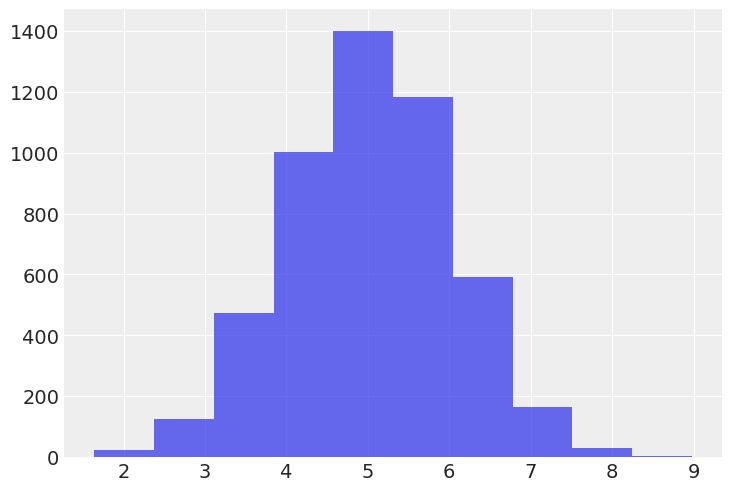

In [83]:
# Create a simple example

import emtk.curves.gaussian as gauss

import numpy as np
import matplotlib.pyplot as plt

curv = gauss.GaussianCurve()

sigma = 1.0
mu = 5.0
pvalues = np.array([mu, sigma])
xrange = np.array([1, 10])
curv.generate_test_samples(pvalues, xrange, 5000)
#curv.generate_background(xrange, 10.0)

measured = curv.data

#est = curv.kde(0.02)

fig,ax = plt.subplots()
hh=ax.hist(measured, alpha=0.7)#, density=True)


In [84]:
import arviz as az
import pymc as pm
import scipy as sp
import scipy.stats
import seaborn as sns
az.style.use("arviz-darkgrid")

model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Normal("mu", mu=4, sigma=3)
    sigma = pm.HalfNormal("sigma", sigma=2)
        
    like = pm.Normal("like", mu=mu, sigma=sigma, observed=measured)

# MAP model is "maximum a posteriori", i.e. find the peak in the
# posterior likelihood like you do for MLE.
map_estimate=pm.find_MAP(model=model)
map_estimate

# That is equivalent what EMTK is doing, so far so good.

{'mu': array(5.02424317),
 'sigma_log__': array(0.01797906),
 'sigma': array(1.01814166)}

## Gaussian With Background

Generated 2000 samples using parameters [5. 1.]


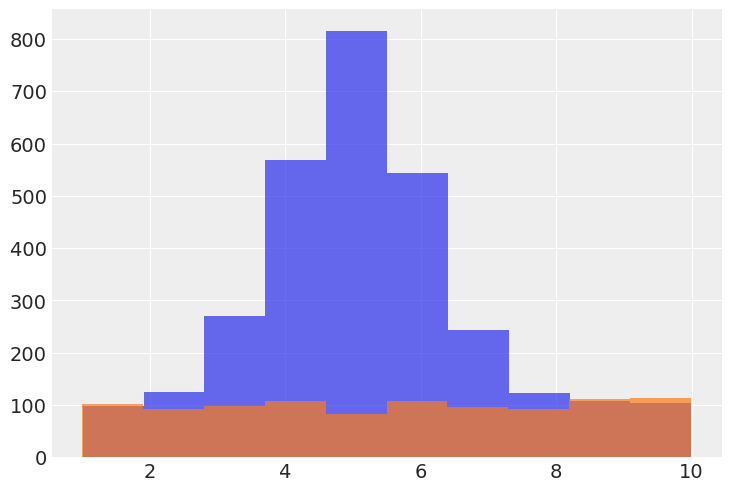

In [85]:
# Create sample measurement and background measurement

import emtk.curves.gaussian as gauss

import numpy as np
import matplotlib.pyplot as plt

curv = gauss.GaussianCurve()

sigma = 1.0
mu = 5.0
pvalues = np.array([mu, sigma])
xrange = np.array([1, 10])
curv.generate_test_samples(pvalues, xrange, 2000)
#curv.generate_background(xrange, 10.0)

sample_bg = np.random.uniform(xrange[0], xrange[1], 1000)
measured_bg = np.random.uniform(xrange[0], xrange[1], 1000)

measured = curv.data
measured = np.append(measured, sample_bg)
np.random.shuffle(measured)


#est = curv.kde(0.02)

fig,ax = plt.subplots()
hh=ax.hist(measured, alpha=0.7)#, density=True)
bb=ax.hist(measured_bg, alpha=0.7)#, density=True)
xgrid = np.arange(2, 8, 0.5)
#xgrid = hh[1]
xgrid = xgrid + 0.5*(xgrid[2]-xgrid[1])
yvals = curv.kde(xgrid)#kdeobject.evaluate(xgrid)


In [86]:
# Now we do the mixture model

import arviz as az
import pymc as pm
import scipy as sp
import scipy.stats
import seaborn as sns
az.style.use("arviz-darkgrid")

model = pm.Model()

with model:
    # mixture model weights
    w = pm.Dirichlet('weights', a=np.array([1,1])) # 2 weights)
    # Dirichlet distribution is a multivariate beta distribution,
    # C.F. simple bayesian inference with a beta distribution
    
    # Priors for unknown gaussian model parameters
    mu_par = pm.Normal("mu", mu=4, sigma=3)
    sigma_par = pm.HalfNormal("sigma", sigma=2)
    
    # Components in overall model - simple version because we are 
    # using different component distributions
    components = [
        pm.Uniform.dist(lower=xrange[0], upper=xrange[1]),
        pm.Normal.dist(mu=mu_par, sigma=sigma_par),
    ]
    
    like = pm.Mixture("like", w=w, comp_dists = components, observed=measured)

map_estimate=pm.find_MAP(model=model)
map_estimate
                    

{'weights_simplex__': array([-0.33894137]),
 'mu': array(5.02441957),
 'sigma_log__': array(-0.00662211),
 'weights': array([0.33673402, 0.66326598]),
 'sigma': array(0.99339977)}

**BINGO**

In [87]:
# Now we use MCMC to sample the distributions properly, and obtain a full statistical analysis.

with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'weights'}>,
        <Axes: title={'center': 'weights'}>]], dtype=object)

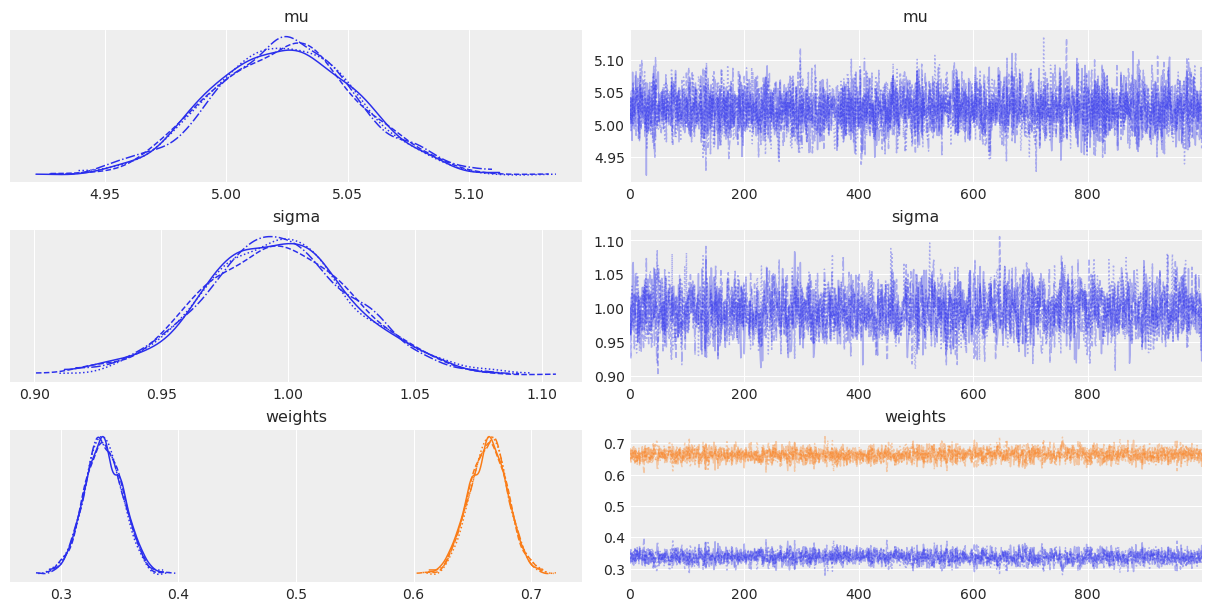

In [88]:
az.plot_trace(idata, var_names=["mu", "sigma", "weights"])

In [89]:
# If we want to do our own statistical analysis on the output, the sample() routine can be called
# with return_inferencedata=False.  This is a much easier object to deal with, to be honest.
with model:
    idata = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [90]:
print(idata.varnames)

['weights_simplex__', 'mu', 'sigma_log__', 'weights', 'sigma']


In [134]:
mu = np.round(np.mean(idata['mu']), decimals = 4)
err_mu = np.round(np.std(idata['mu']), decimals=4)
sigma = np.round(np.mean(idata['sigma']), decimals=4)
err_sigma = np.round(np.std(idata['sigma']), decimals=4)

bg_weight = np.mean(idata['weights'][:,0])
signal_weight = np.mean(idata['weights'][:,1])

print("Loc.  = ", mu, "+/-", err_mu)
print("Sigma = ", sigma, "+/-", err_sigma)
print("Background weight = ", np.round(bg_weight, decimals = 3))
print("Signal weight = ", np.round(signal_weight, decimals = 3))

Loc.  =  5.0249 +/- 0.0287
Sigma =  0.9946 +/- 0.0291
Background weight =  0.337
Signal weight =  0.663


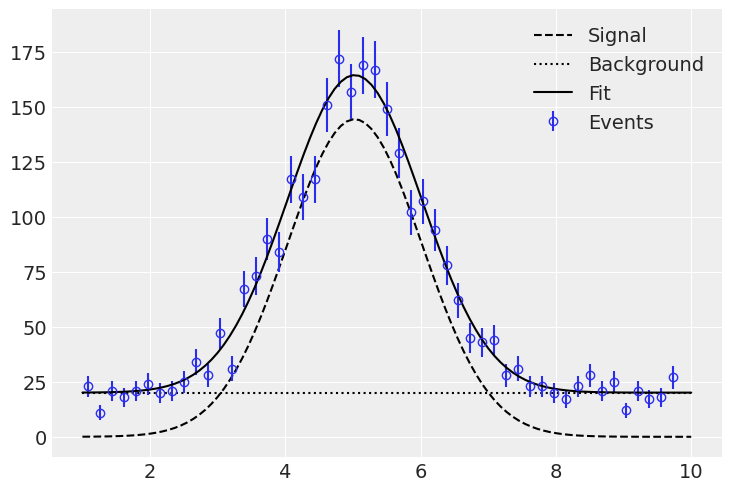

In [126]:

nx = 100.0
nh = 50.0

xi = np.linspace(xrange[0], xrange[1], int(nx))
hbins = np.arange(xrange[0], xrange[1], (xrange[1]-xrange[0])/(nh + 1.0))

# Normalise the signal component
fit_signal = sp.stats.norm.pdf(xi, loc=mu, scale=sigma)
fit_signal = signal_weight * fit_signal / np.sum(fit_signal)

# Normalise the background component
# This next one is brainless but done for the sake of consistency
fit_bg = sp.stats.uniform.pdf(xi, loc=xrange[0], scale=(xrange[1]-xrange[0]))
fit_bg = bg_weight * fit_bg / (np.sum(fit_bg)) # * (xrange[1]-xrange[0]))

fit_total = fit_signal + fit_bg

# Get the measured data histogrammed up with error bars
hst = np.histogram(measured, bins=hbins)
rl = np.roll(hbins, -1)
xhist = 0.5*(hbins+rl)
xhist = np.delete(xhist,-1)
yvals = hst[0]
errors= np.sqrt(yvals)

sumhist = np.sum(yvals)

sumfit = np.sum(fit_total)

scale = (nx / nh) * (sumhist / sumfit)

fit_signal = fit_signal * scale
fit_bg = fit_bg * scale
fit_total = fit_total * scale

fig, ax = plt.subplots()
ax.plot(xi, fit_signal, color='black',linestyle="dashed", label="Signal")
ax.plot(xi, fit_bg, color='black', linestyle="dotted", label="Background")
ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
ax.plot(xi, fit_total, color='black', label="Fit")
ax.legend()

# Statistical Comparison to LSE with Noisy Gaussian

In [126]:
import pymc as pm
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt


xmin = 0.0
xmax = 10.0


def generate_data(npoints, xmin=1.0, xmax=10.0, mu=5.0, sigma=1.0, sn_ratio = 3.0):
    bgfrac = 1.0 / (sn_ratio + 1.0)
    
    nbg = int(np.floor(npoints * bgfrac))
    nsig = npoints - nbg
    
    signal = sp.stats.norm.rvs(size=nsig, loc=mu, scale=sigma)
    background = sp.stats.uniform.rvs(size=nbg, loc=xmin, scale=(xmax+xmin))
    result = np.concatenate((signal, background))
    np.random.shuffle(result)
    
    return result


def bayesian_fit(spectrum, xmin, xmax, plot=False, verbose=True):

    npts = spectrum.size
    
    model = pm.Model()

    with model:
        # mixture model weights
        w = pm.Dirichlet('weights', a=np.array([1,1])) # 2 weights)
        # Dirichlet distribution is a multivariate beta distribution,
        # C.F. simple bayesian inference with a beta distribution
    
        # Priors for unknown gaussian model parameters
        mu_par = pm.Normal("mu", mu=4, sigma=4)
        sigma_par = pm.HalfNormal("sigma", sigma=3)
    
        # Components in overall model - simple version because we are 
        # using different component distributions
        components = [
            pm.Uniform.dist(lower=xmin, upper=xmax),
            pm.Normal.dist(mu=mu_par, sigma=sigma_par),
        ]
    
        like = pm.Mixture("like", w=w, comp_dists = components, observed=spectrum)

        idata = pm.sample(return_inferencedata=False)
        
        mu = np.round(np.mean(idata['mu']), decimals = 4)
        err_mu = np.round(np.std(idata['mu']), decimals=4)
        sigma = np.round(np.mean(idata['sigma']), decimals=4)
        err_sigma = np.round(np.std(idata['sigma']), decimals=4)

        bg_weight = np.mean(idata['weights'][:,0])
        signal_weight = np.mean(idata['weights'][:,1])

        if verbose:
            print("Data size:", npts)
            print("Loc.  = ", mu, "+/-", err_mu)
            print("Sigma = ", sigma, "+/-", err_sigma)
            print("Background weight = ", np.round(bg_weight, decimals = 3))
            print("Signal weight = ", np.round(signal_weight, decimals = 3))
            
            
        if plot:
                
            nx = 100.0
            nh = 50.0

            xi = np.linspace(xmin, xmax, int(nx))
            hbins = np.arange(xmin, xmax, (xmax-xmin)/(nh + 1.0))

            # Normalise the signal component
            fit_signal = sp.stats.norm.pdf(xi, loc=mu, scale=sigma)
            fit_signal = signal_weight * fit_signal / np.sum(fit_signal)

            # Normalise the background component
            # This next one is brainless but done for the sake of consistency
            fit_bg = sp.stats.uniform.pdf(xi, loc=xmin, scale=(xmin + xmax))
            fit_bg = bg_weight * fit_bg / (np.sum(fit_bg)) # * (xrange[1]-xrange[0]))

            fit_total = fit_signal + fit_bg

            # Get the measured data histogrammed up with error bars
            hst = np.histogram(spectrum, bins=hbins)
            rl = np.roll(hbins, -1)
            xhist = 0.5*(hbins+rl)
            xhist = np.delete(xhist,-1)
            yvals = hst[0]
            errors= np.sqrt(yvals)

            sumhist = np.sum(yvals)

            sumfit = np.sum(fit_total)

            scale = (nx / nh) * (sumhist / sumfit)

            fit_signal = fit_signal * scale
            fit_bg = fit_bg * scale
            fit_total = fit_total * scale

            fig, ax = plt.subplots()
            ax.plot(xi, fit_signal, color='black',linestyle="dashed", label="Signal")
            ax.plot(xi, fit_bg, color='black', linestyle="dotted", label="Background")
            ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
            ax.plot(xi, fit_total, color='black', label="Fit")
            ax.legend()

        return sigma, err_sigma
            
nspectra = 10
sizes = np.round(np.logspace(1, 4, num=nspectra))
print(sizes)

spectra = []
bayesian_widths = []
bayesian_variances = []
least_squares_widths = []
least_squares_variances = []

test_spectrum = generate_data(3000, xmin=xmin, xmax=xmax, sn_ratio=3.0)

for i in range(nspectra):
    spectrum = generate_data(int(sizes[i]), xmin=xmin, xmax=xmax, sn_ratio=3.0)
    spectra.append(spectrum)



[   10.    22.    46.   100.   215.   464.  1000.  2154.  4642. 10000.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Data size: 3000
Loc.  =  5.032 +/- 0.0251
Sigma =  1.0037 +/- 0.0231
Background weight =  0.263
Signal weight =  0.737


(1.0037, 0.0231)

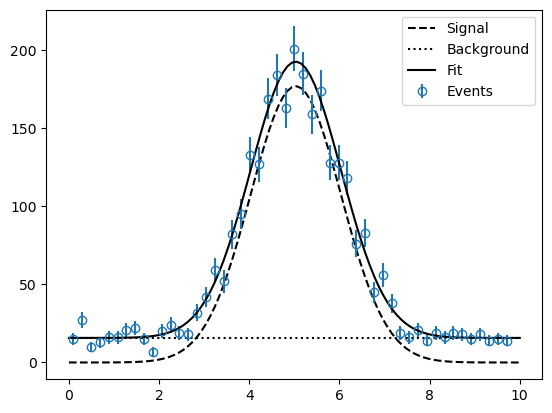

In [22]:
# Before we waste time looping, make sure that the test works correctly
bayesian_fit(test_spectrum, plot=True, xmin=xmin, xmax=xmax)

In [127]:
for i in range(nspectra):
    width, variance = bayesian_fit(spectra[i], xmin=xmin, xmax=xmax, plot=False)
    bayesian_widths.append(width)
    bayesian_variances.append(variance)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Data size: 10
Loc.  =  5.113 +/- 0.3403
Sigma =  0.4421 +/- 0.5645
Background weight =  0.422
Signal weight =  0.578


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Data size: 22
Loc.  =  4.7306 +/- 0.1824
Sigma =  0.6623 +/- 0.1629
Background weight =  0.271
Signal weight =  0.729


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Data size: 46
Loc.  =  5.2154 +/- 0.2507
Sigma =  1.1273 +/- 0.2418
Background weight =  0.234
Signal weight =  0.766


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Data size: 100
Loc.  =  4.9203 +/- 0.1183
Sigma =  0.8668 +/- 0.1108
Background weight =  0.246
Signal weight =  0.754


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Data size: 215
Loc.  =  5.0362 +/- 0.0962
Sigma =  0.9959 +/- 0.0912
Background weight =  0.273
Signal weight =  0.727


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Data size: 464
Loc.  =  5.1584 +/- 0.0636
Sigma =  0.9708 +/- 0.0561
Background weight =  0.277
Signal weight =  0.723


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Data size: 1000
Loc.  =  4.9969 +/- 0.0436
Sigma =  0.9798 +/- 0.041
Background weight =  0.256
Signal weight =  0.744


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Data size: 2154
Loc.  =  5.0085 +/- 0.0297
Sigma =  0.994 +/- 0.0272
Background weight =  0.243
Signal weight =  0.757


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Data size: 4642
Loc.  =  4.9986 +/- 0.0204
Sigma =  0.9884 +/- 0.0194
Background weight =  0.262
Signal weight =  0.738


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Data size: 10000
Loc.  =  4.9729 +/- 0.0141
Sigma =  1.0078 +/- 0.0134
Background weight =  0.252
Signal weight =  0.748


In [128]:
from lmfit import Model


def gaussian_ls_func(x, amp, mu, sigma, bg):
    first = amp / (sigma * np.sqrt(2.0 * np.pi))
    
    second = np.exp(-0.5 * ((x-mu)/sigma)**2.0)
    
    return first * second + bg

def ls_fit(spectrum, xmin=0.0, xmax=10.0, plot=False, verbose=True):

    mu_guess = np.mean(spectrum)   # actually MLE so should be close
    sigma_guess = 0.5 * np.std(spectrum) # likewise

    gmodel = Model(gaussian_ls_func)
    
    nx = 100.0
    nh = 50.0

    xi = np.linspace(xmin, xmax, int(nx))
    hbins = np.arange(xmin, xmax, (xmax-xmin)/(nh + 1.0))

    hst = np.histogram(spectrum, bins=hbins)
    rl = np.roll(hbins, -1)
    xhist = 0.5*(hbins+rl)
    xhist = np.delete(xhist,-1)
    yvals = hst[0]
    errors= np.sqrt(yvals)
    
    bg_guess = yvals[0]
    amp_guess = np.amax(yvals)
    
    result = gmodel.fit(yvals, x=xhist, amp=amp_guess, mu=mu_guess, sigma=sigma_guess, bg=bg_guess)
    
    if verbose:
        print(result.fit_report())
    
    if plot:
        fig, ax = plt.subplots()
        ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
        ax.plot(xhist, result.init_fit, '--', color='black', label="LSE initial")
        ax.plot(xhist, result.best_fit, color='black', label="LSE fit")
        ax.legend()
    
    width = result.params["sigma"].value
    variance = result.params["sigma"].stderr
        
    return width, variance
    
    



In [90]:
# Before we waste time looping, make sure that the test works correctly
test_result = ls_fit(test_spectrum, plot=False, verbose=True, xmin=xmin, xmax=xmax)

[[Model]]
    Model(gaussian_ls_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 50
    # variables        = 4
    chi-square         = 1815.71592
    reduced chi-square = 39.4720852
    Akaike info crit   = 187.610605
    Bayesian info crit = 195.258698
    R-squared          = 0.99003414
[[Variables]]
    amp:    444.634364 +/- 9.52707769 (2.14%) (init = 191)
    mu:     4.99434004 +/- 0.01676639 (0.34%) (init = 5.022913)
    sigma:  1.00425937 +/- 0.01982917 (1.97%) (init = 0.8390158)
    bg:     14.2873458 +/- 1.31671036 (9.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, bg)    = -0.7380
    C(amp, sigma) = +0.7234
    C(sigma, bg)  = -0.5339


In [88]:
test_result.params["sigma"].stderr

0.01982916951166053

In [129]:
least_squares_widths=[]
least_squares_variances=[]

for i in range(nspectra):
    width, variance = ls_fit(spectra[i], xmin=xmin, xmax=xmax, plot=False, verbose=False)
    least_squares_widths.append(width)
    least_squares_variances.append(variance)

Text(0.5, 1.0, 'Bayesian MAP')

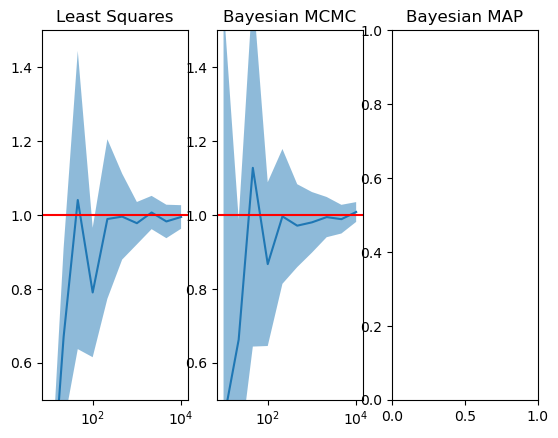

In [131]:
fig,ax=plt.subplots(1,3)

# 2 sigma (95%) bands

ls_lower = np.asarray(least_squares_widths) - 2.0 * np.asarray(least_squares_variances)
ls_upper = np.asarray(least_squares_widths) + 2.0 * np.asarray(least_squares_variances)

by_lower = np.asarray(bayesian_widths) - 2.0 * np.asarray(bayesian_variances)
by_upper = np.asarray(bayesian_widths) + 2.0 * np.asarray(bayesian_variances)

ax[0].plot(sizes, least_squares_widths)
ax[0].fill_between(sizes, y1=ls_lower, y2=ls_upper, alpha=0.5) 
ax[1].plot(sizes, bayesian_widths)
ax[1].fill_between(sizes, y1=by_lower, y2=by_upper, alpha = 0.5)

ax[0].set_xscale('log')
ax[0].set_ylim(0.5, 1.5)
ax[0].set_title('Least Squares')
ax[0].axhline(y=1.0, color='r', linestyle='-')

ax[1].set_xscale('log')
ax[1].set_ylim(0.5, 1.5)
ax[1].set_title('Bayesian MCMC')
ax[1].axhline(y=1.0, color='r', linestyle='-')

ax[2].set_title('Bayesian MAP')